In [1]:
!pip install torchsummary
!pip install grad-cam
!pip install torch-lr-finder

In [1]:
!git clone https://github.com/gupta1912/ERA-V1-Assignments.git

Cloning into 'ERA-V1-Assignments'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 123 (delta 32), reused 105 (delta 17), pack-reused 0
Receiving objects: 100% (123/123), 2.28 MiB | 13.72 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [2]:
cd ERA-V1-Assignments/S11

/content/ERA-V1-Assignments/S11


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torchsummary import summary

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
from models.resnet import ResNet18
from dataloader import Cifar10SearchDataset
from utils import CustomResnetTransforms, visualise_train_images, \
                  plot_curves, get_misclassified_images, plot_misclassified, plot_grad_cam_images
from main import get_dataloader, train, test, find_lr, get_scheduler, get_dataloader

In [5]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

train_transforms = CustomResnetTransforms.train_transforms(means, stds)
test_transforms = CustomResnetTransforms.test_transforms(means, stds)

train_set = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test_set = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

cuda
Files already downloaded and verified
Files already downloaded and verified


In [6]:
SEED = 1

# For reproducibility
torch.manual_seed(SEED)

# train dataloader
train_loader = get_dataloader(train_set, batch_size=512)

# test dataloader
test_loader = get_dataloader(test_set, batch_size=512)

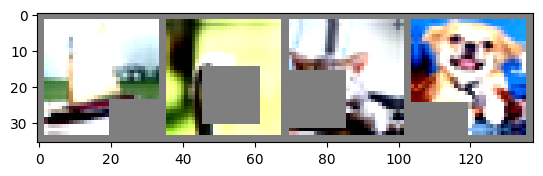

ship  bird  cat   dog  


In [7]:
# get some random training images
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
visualise_train_images(train_loader, classes)

In [8]:
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.00E-02


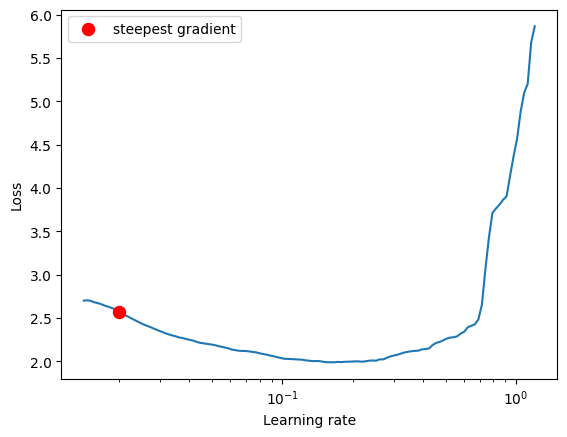

In [9]:
model = ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
find_lr(model, optimizer, criterion, train_loader, device)

In [10]:
suggested_lr = 2.00E-02

In [11]:
model =  ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
EPOCHS = 20

scheduler = get_scheduler(optimizer, train_loader, suggested_lr, EPOCHS)

criterion = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')
    train_losses, train_acc = train(model, device, train_loader, optimizer, criterion, scheduler, train_losses, train_acc)
    test_losses, test_acc = test(model, device, test_loader, criterion, test_losses, test_acc)

Epoch 1


Train: Loss=1.1924 Batch_id=97 Accuracy=42.88: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 1.3935, Accuracy: 5113/10000 (51.13%)

Epoch 2


Train: Loss=1.1010 Batch_id=97 Accuracy=56.35: 100%|██████████| 98/98 [00:43<00:00,  2.28it/s]


Test set: Average loss: 1.2522, Accuracy: 5927/10000 (59.27%)

Epoch 3


Train: Loss=0.9624 Batch_id=97 Accuracy=63.48: 100%|██████████| 98/98 [00:45<00:00,  2.18it/s]


Test set: Average loss: 1.3577, Accuracy: 5639/10000 (56.39%)

Epoch 4


Train: Loss=0.8577 Batch_id=97 Accuracy=66.38: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Test set: Average loss: 0.8817, Accuracy: 6893/10000 (68.93%)

Epoch 5


Train: Loss=0.9610 Batch_id=97 Accuracy=68.98: 100%|██████████| 98/98 [00:44<00:00,  2.19it/s]


Test set: Average loss: 0.9248, Accuracy: 6924/10000 (69.24%)

Epoch 6


Train: Loss=0.8346 Batch_id=97 Accuracy=70.48: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]


Test set: Average loss: 0.9208, Accuracy: 6932/10000 (69.32%)

Epoch 7


Train: Loss=0.8770 Batch_id=97 Accuracy=72.25: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]


Test set: Average loss: 0.7973, Accuracy: 7241/10000 (72.41%)

Epoch 8


Train: Loss=0.6439 Batch_id=97 Accuracy=73.69: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]


Test set: Average loss: 0.8546, Accuracy: 7130/10000 (71.30%)

Epoch 9


Train: Loss=0.6104 Batch_id=97 Accuracy=75.29: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Test set: Average loss: 0.8374, Accuracy: 7151/10000 (71.51%)

Epoch 10


Train: Loss=0.6034 Batch_id=97 Accuracy=76.21: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]


Test set: Average loss: 0.6196, Accuracy: 7832/10000 (78.32%)

Epoch 11


Train: Loss=0.6305 Batch_id=97 Accuracy=77.19: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Test set: Average loss: 0.7437, Accuracy: 7517/10000 (75.17%)

Epoch 12


Train: Loss=0.5473 Batch_id=97 Accuracy=78.08: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]


Test set: Average loss: 0.7855, Accuracy: 7552/10000 (75.52%)

Epoch 13


Train: Loss=0.5886 Batch_id=97 Accuracy=79.48: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]


Test set: Average loss: 0.6201, Accuracy: 8002/10000 (80.02%)

Epoch 14


Train: Loss=0.5665 Batch_id=97 Accuracy=80.11: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]


Test set: Average loss: 0.5284, Accuracy: 8207/10000 (82.07%)

Epoch 15


Train: Loss=0.5365 Batch_id=97 Accuracy=81.72: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]


Test set: Average loss: 0.4820, Accuracy: 8395/10000 (83.95%)

Epoch 16


Train: Loss=0.4240 Batch_id=97 Accuracy=82.88: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]


Test set: Average loss: 0.4433, Accuracy: 8528/10000 (85.28%)

Epoch 17


Train: Loss=0.4352 Batch_id=97 Accuracy=84.31: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]


Test set: Average loss: 0.4081, Accuracy: 8658/10000 (86.58%)

Epoch 18


Train: Loss=0.3384 Batch_id=97 Accuracy=86.24: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]


Test set: Average loss: 0.3644, Accuracy: 8800/10000 (88.00%)

Epoch 19


Train: Loss=0.3380 Batch_id=97 Accuracy=88.26: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Test set: Average loss: 0.3051, Accuracy: 8985/10000 (89.85%)

Epoch 20


Train: Loss=0.2436 Batch_id=97 Accuracy=90.27: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]


Test set: Average loss: 0.2651, Accuracy: 9124/10000 (91.24%)



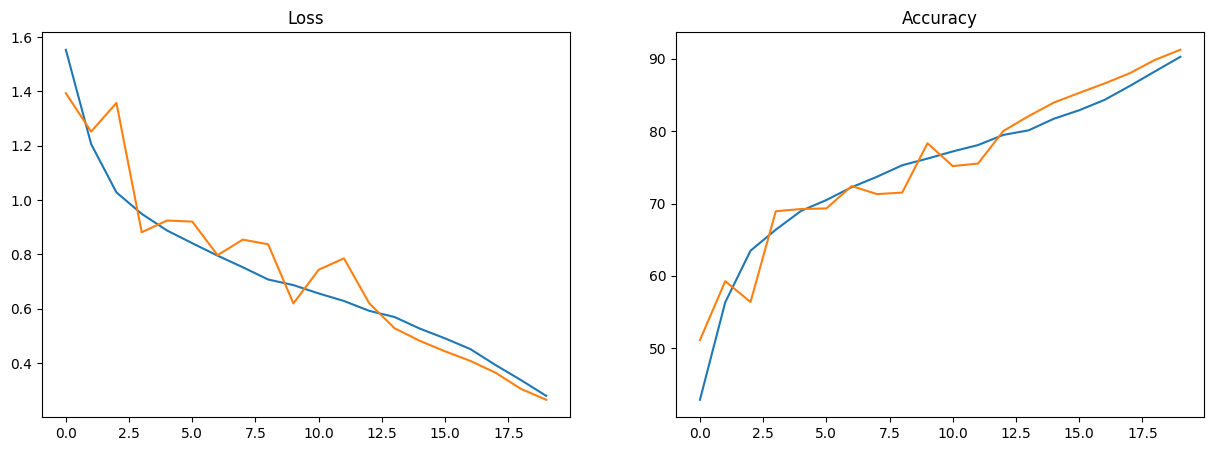

In [12]:
#plot of loss and accuracy curve
plot_curves(train_losses, train_acc, test_losses, test_acc)

In [13]:
#finding misclassifies images and ploting misclassified images
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True)

misclassified_images, misclassified_predictions, true_targets = get_misclassified_images(model, cifar_testset, means, stds, device)

Files already downloaded and verified


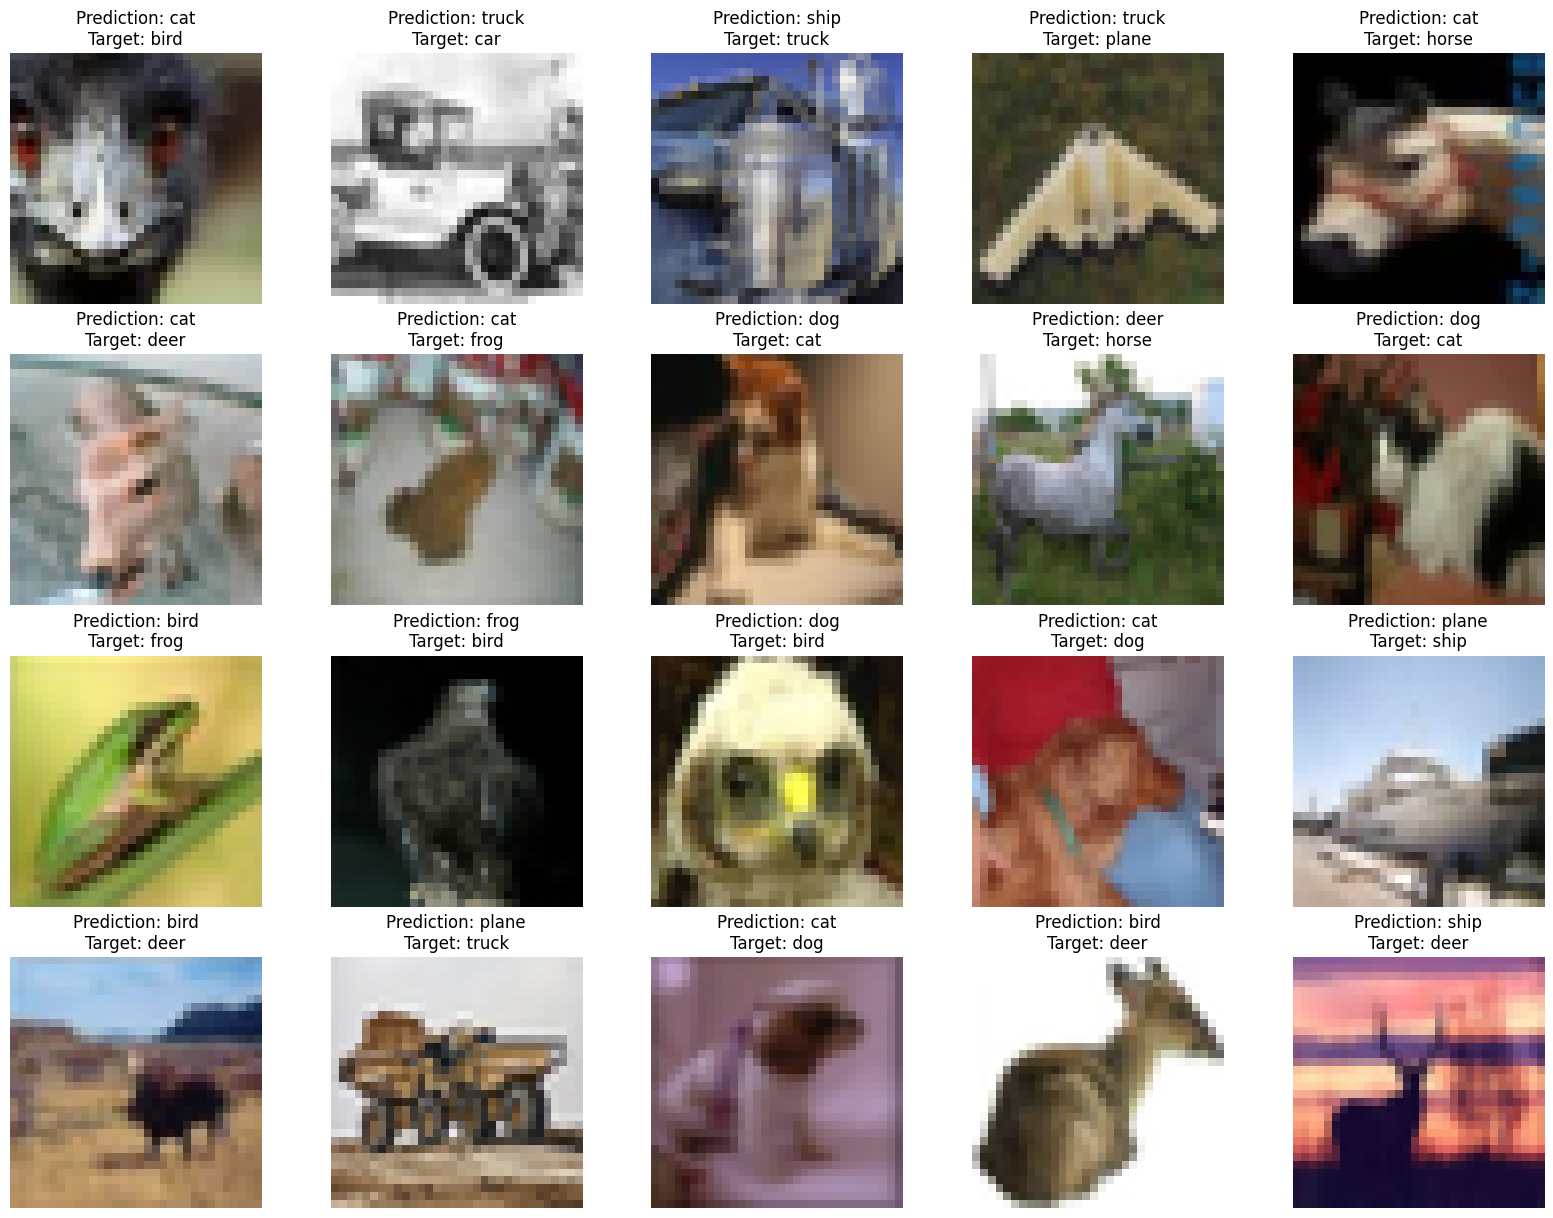

In [14]:
plot_misclassified(misclassified_images, misclassified_predictions, true_targets, classes)

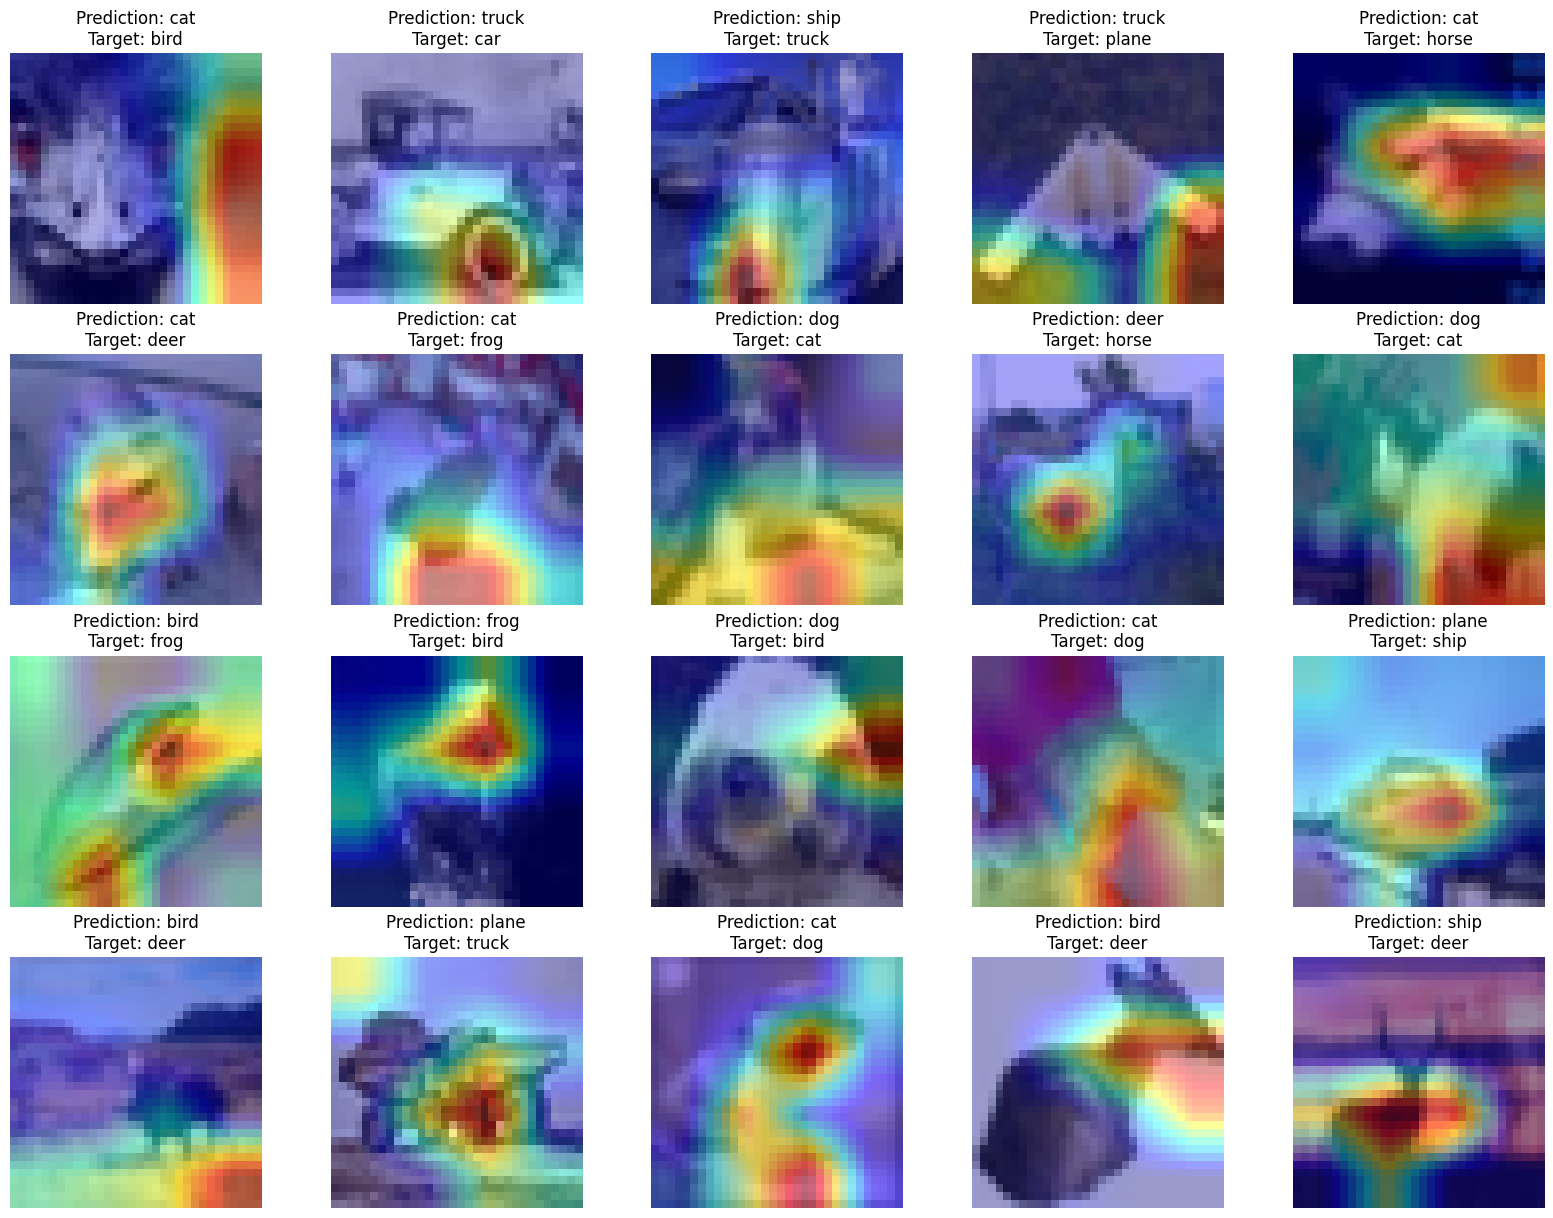

In [18]:
plot_grad_cam_images(misclassified_images, misclassified_predictions, true_targets, classes, model)